In [ ]:
from scipy import io
import os
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
%matplotlib inline
import utils_cvPCA

os.chdir('c:\\Python\\molanalysis\\cvPCA')
# dat = io.loadmat('/media/carsen/DATA2/grive/10krecordings/imgResp/natimg2800_M170714_MP032_2017-09-14.mat')
dat = io.loadmat('natimg2800_M170714_MP032_2017-09-14.mat')
# dat = io.loadmat('/cvPCA/natimg2800_M170714_MP032_2017-09-14.mat')

resp = dat['stim'][0]['resp'][0] # stim x neurons
spont = dat['stim'][0]['spont'][0] # timepts x neurons
istim = (dat['stim'][0]['istim'][0]).astype(np.int32) # stim ids 
istim -= 1 # get out of MATLAB convention
istim = istim[:,0]
nimg = istim.max() # these are blank stims (exclude them)
resp = resp[istim<nimg, :]
istim = istim[istim<nimg]

# subtract spont (32D)
mu = spont.mean(axis=0)
sd = spont.std(axis=0) + 1e-6
resp = (resp - mu) / sd
spont = (spont - mu) / sd
sv,u = eigsh(spont.T @ spont, k=32)
resp = resp - (resp @ u) @ u.T

# mean center each neuron
resp -= resp.mean(axis=0)

(array([2., 2., 3., ..., 3., 2., 3.]),
 array([0.00000000e+00, 9.99642857e-01, 1.99928571e+00, ...,
        2.79700071e+03, 2.79800036e+03, 2.79900000e+03]),
 <BarContainer object of 2800 artists>)

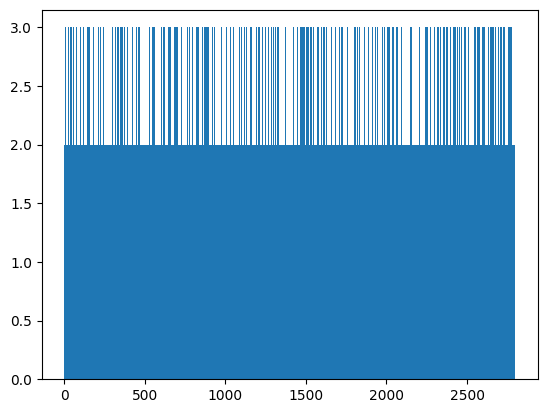

In [ ]:
resp.shape
# # spont.shape
istim.shape
# print(np.unique(istim))
# plt.hist(istim,bins=2800)
# nimg
# os.getcwd()
# istim

In [5]:
import pandas as pd
import scipy.stats as st
os.chdir('e:\\Python\\molanalysis\\')
from loaddata.session_info import filter_sessions,load_sessions
from utils.plotting_style import * #get all the fixed color schemes

from utils.imagelib import load_natural_images #
from utils.corr_lib import mean_resp_image

#################################################
# session_list        = np.array([['LPE09665','2023_03_15']])
session_list        = np.array([['LPE11086','2023_12_16']])
sessions,nSessions            = load_sessions(protocol = 'IM',session_list=session_list,load_behaviordata=True, 
                                    load_calciumdata=True, load_videodata=True, calciumversion='deconv')

#%% Load sessions lazy: 
# sessions,nSessions   = load_sessions(protocol = 'IM',session_list=session_list)

#%%   Load proper data and compute average trial responses:                      
for ises in range(nSessions):    # iterate over sessions
    # sessions[ises].load_respmat(load_behaviordata=True, load_calciumdata=True,load_videodata=True,calciumversion='deconv')
    sessions[ises].load_respmat(calciumversion='deconv',keepraw=True)

['IM'] dataset: 1 mice, 1 sessions, 5600 trials
Number of neurons in PM: 903
Number of neurons in V1: 1682
Total number of neurons: 2585


In [23]:
resp = sessions[0].respmat.T
np.shape(resp)
istim = np.array(sessions[0].trialdata['ImageNumber'])
istim
nimg = istim.max() + 1 # these are blank stims (exclude them)
nimg

# mean center each neuron
resp -= resp.mean(axis=0)
resp = resp / (resp.std(axis=0) + 1e-6)


In [24]:
### sanity check - decent signal variance ?
# split stimuli into two repeats
NN = resp.shape[1]
sresp = np.zeros((2, nimg, NN), np.float64)
inan = np.zeros((nimg,)).astype(bool)
for n in range(nimg):
    ist = (istim==n).nonzero()[0]
    i1 = ist[:int(ist.size/2)]
    i2 = ist[int(ist.size/2):]
    # check if two repeats of stim
    if np.logical_or(i2.size < 1, i1.size < 1):
        inan[n] = 1
    else:
        sresp[0, n, :] = resp[i1, :].mean(axis=0)
        sresp[1, n, :] = resp[i2, :].mean(axis=0)
        
# remove image responses without two repeats
sresp = sresp[:,~inan,:]
    
# normalize the responses across images
# Subtract that mean, and divide by std — this makes the response of each neuron
# for each repeat zero-mean and unit-variance across stimuli.
# So now, for each neuron, the normalized responses to different stimuli 
# are on the same scale in both repeats.
snorm = sresp - sresp.mean(axis=1)[:,np.newaxis,:]
snorm = snorm / (snorm.std(axis=1)[:,np.newaxis,:] + 1e-6)

#Get the correlation of each neuron's response across repeats
cc = (snorm[0].T @ snorm[1]) / sresp.shape[1]
#print the mean correlation coeff:
print('fraction of signal variance: %2.3f'%np.diag(cc).mean())

fraction of signal variance: 0.165


(array([  1.,   0.,   0.,   3.,   3.,   5.,  13.,  20.,  28.,  46.,  72.,
         98., 125., 191., 215., 252., 239., 261., 299., 284., 274., 297.,
        275., 264., 283., 234., 222., 228., 219., 241., 225., 197., 203.,
        212., 159., 176., 168., 188., 170., 155., 172., 168., 164., 150.,
        127., 132., 120.,  99., 101., 110., 118., 101.,  85.,  90.,  86.,
         72.,  71.,  78.,  89.,  65.,  45.,  52.,  66.,  49.,  38.,  34.,
         46.,  40.,  35.,  31.,  29.,  27.,  20.,  32.,  26.,  18.,  15.,
         10.,  16.,  12.,  16.,  23.,   6.,   6.,   6.,   8.,   4.,   3.,
          4.,   5.,   0.,   2.,   3.,   1.,   0.,   1.,   1.,   1.,   1.,
          1.]),
 array([-6.12815496e-02, -5.45376879e-02, -4.77938263e-02, -4.10499646e-02,
        -3.43061029e-02, -2.75622413e-02, -2.08183796e-02, -1.40745179e-02,
        -7.33065629e-03, -5.86794623e-04,  6.15706704e-03,  1.29009287e-02,
         1.96447904e-02,  2.63886520e-02,  3.31325137e-02,  3.98763754e-02,
         4.662

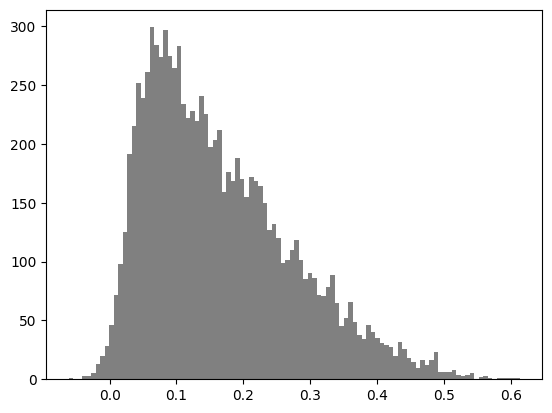

In [ ]:
# make a histogram of the corr coefs for all neurons:
plt.hist(np.diag(cc),bins=100,color='grey')

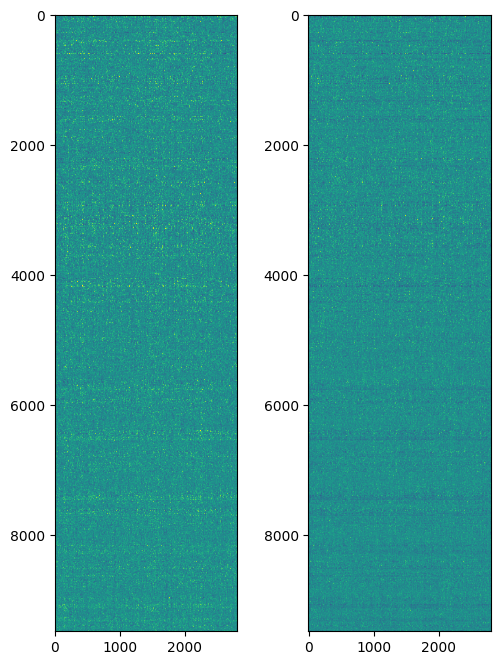

In [21]:
fig,axes = plt.subplots(1,2,figsize=(6,8))
ax = axes[0]
ax.imshow(sresp[0].T,vmin=-1,vmax=1)
ax = axes[1]
ax.imshow(sresp[1].T,vmin=-1,vmax=1)

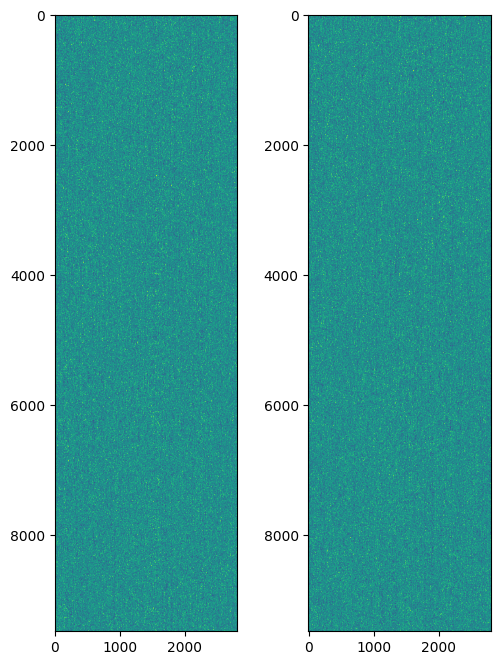

In [18]:
fig,axes = plt.subplots(1,2,figsize=(6,8))
ax = axes[0]
ax.imshow(snorm[0].T,vmin=-0.5,vmax=0.5)
ax = axes[1]
ax.imshow(snorm[1].T,vmin=-0.5,vmax=0.5)

In [8]:
sresp.shape
cc = sresp[0] @ sresp[1].T
np.shape(cc)

(2800, 2800)

In [25]:
### sanity check - decent decoding ?
# 1 nearest neighbor decoder    
# (mean already subtracted)
# sresp = snorm
cc = sresp[0] @ sresp[1].T
cc /= (sresp[0]**2).sum()
cc /= (sresp[1]**2).sum()
nstims = sresp.shape[1]
print('decoding accuracy: %2.3f'%(cc.argmax(axis=1)==np.arange(0,nstims,1,int)).mean())

decoding accuracy: 0.412


In [34]:
from utils.shuffle_lib import my_shuffle

sresp[0,:,:] = my_shuffle(sresp[0,:,:],method='random')
sresp[1,:,:] = my_shuffle(sresp[1,:,:],method='random')


powerlaw, alpha=0.968


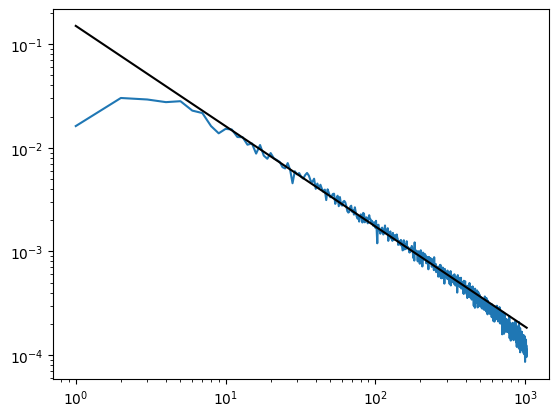

In [30]:
### sanity check - is the powerlaw close to 1 ?
# powerlaw

# compute cvPCA
# ss = utils_cvPCA.shuff_cvPCA(sresp)
# ss = ss.mean(axis=0)

ss = utils_cvPCA.cvPCA(sresp)

# compute powerlaw of averaged shuffles
alpha,ypred = utils_cvPCA.get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()


In [34]:
import numpy as np
from scipy.sparse.linalg import eigsh
from sklearn.decomposition import PCA

X = sresp

# do PCA on data
pca = PCA(n_components=min(1024, X.shape[1])).fit(X[0].T)
# get the components
u = pca.components_.T
# get the singular values
sv = pca.singular_values_


In [ ]:
# project train data onto components
xproj = X[0].T @ (u / sv)
# project train data onto components
cproj0 = X[0] @ xproj
# project test data onto components
cproj1 = X[1] @ xproj

# compute the correlation between the two sets of components
ss = (cproj0 * cproj1).sum(axis=0)


In [49]:
np.shape(pca.transform(X[0].T))

(9476, 1024)

In [54]:
np.shape(u)

(2800, 1024)

powerlaw, alpha=1.641


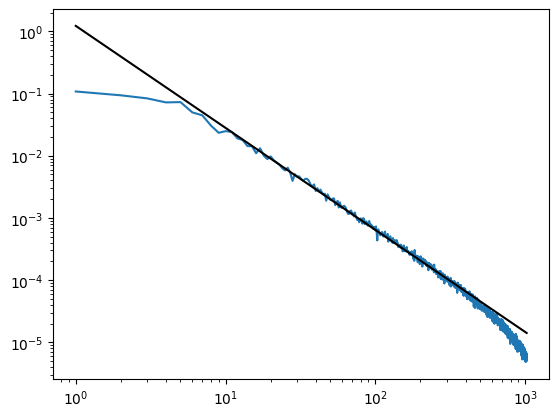

In [52]:
# compute powerlaw of averaged shuffles
alpha,ypred = utils_cvPCA.get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()